In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

Load data

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Analyse label distribution

=== Training Dataset Analysis ===

=== Text Statistics ===
Mean text length: 5596.68
Median text length: 4020.00
Min text length: 1001.00
Max text length: 100568.00
Mean word count: 888.37
Median word count: 639.00

=== Label Distribution ===
true: 1185 (60.83%)
fake: 514 (26.39%)
biased: 249 (12.78%)


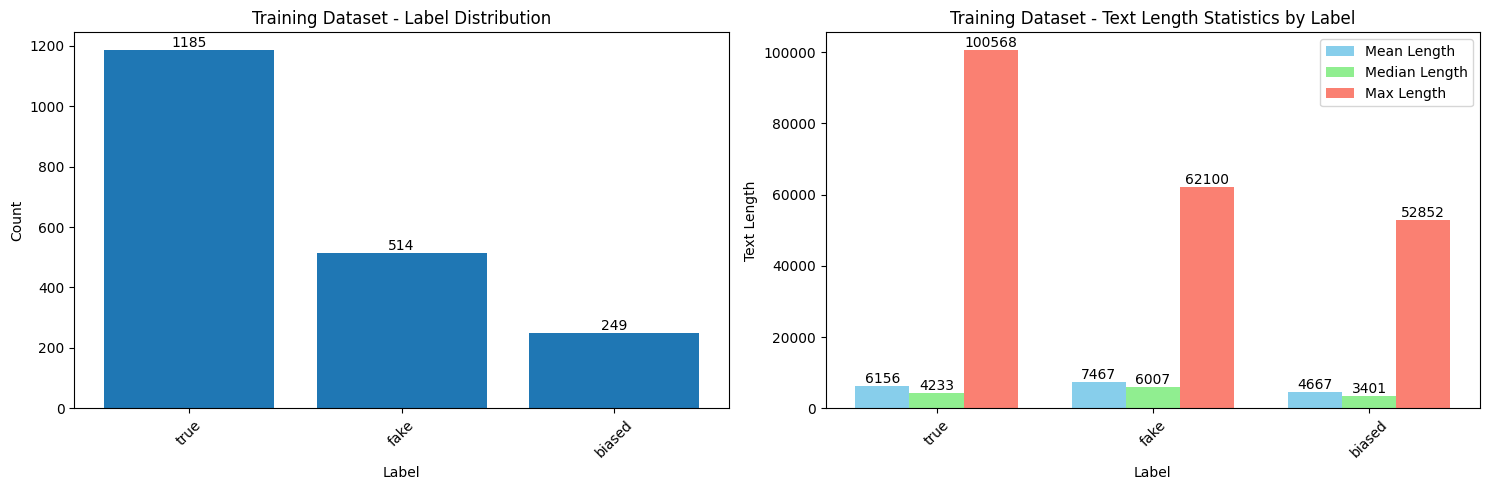

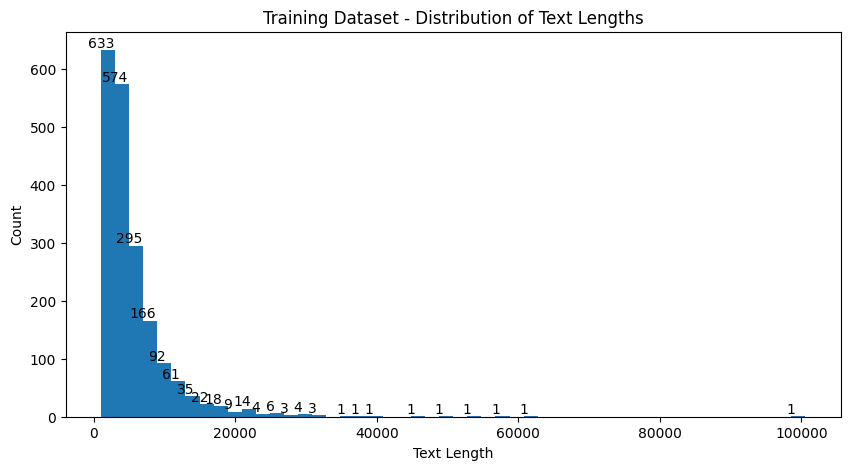

=== Test Dataset Analysis ===

=== Text Statistics ===
Mean text length: 5372.96
Median text length: 3721.00
Min text length: 1057.00
Max text length: 42164.00
Mean word count: 852.15
Median word count: 599.50


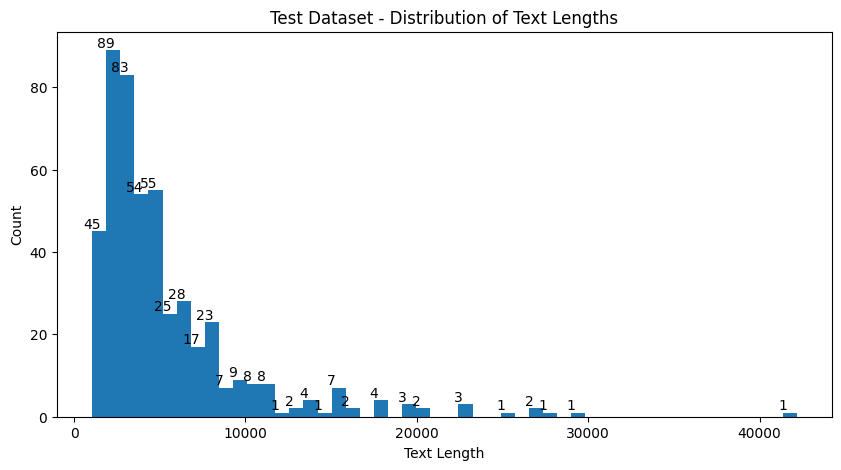

In [9]:
def inspect_dataset(df, name="Dataset", skip_label_analysis=False):
    print(f"=== {name} Analysis ===")
    
    # Text analysis
    df['text_length'] = df['Text'].str.len()
    df['word_count'] = df['Text'].str.split().str.len()
    
    print("\n=== Text Statistics ===")
    text_stats = {
        'Mean text length': df['text_length'].mean(),
        'Median text length': df['text_length'].median(),
        'Min text length': df['text_length'].min(),
        'Max text length': df['text_length'].max(),
        'Mean word count': df['word_count'].mean(),
        'Median word count': df['word_count'].median()
    }
    for stat, value in text_stats.items():
        print(f"{stat}: {value:.2f}")
    
    if 'Label' in df.columns and not skip_label_analysis:
        print("\n=== Label Distribution ===")
        label_dist = df['Label'].value_counts()
        label_percentages = (label_dist / len(df) * 100).round(2)
        
        for label, count in label_dist.items():
            percentage = label_percentages[label]
            print(f"{label}: {count} ({percentage}%)")
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        labels = label_dist.index
        counts = label_dist.values
        bars = plt.bar(labels, counts)
        plt.title(f'{name} - Label Distribution')
        plt.xticks(rotation=45)
        plt.xlabel('Label')
        plt.ylabel('Count')
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom')
        
        plt.subplot(1, 2, 2)
        stats_by_label = df.groupby('Label')['text_length'].agg(['mean', 'median', 'max'])
        
        x = np.arange(len(labels))
        width = 0.25
        
        bar1 = plt.bar(x - width, stats_by_label['mean'], width, label='Mean Length', color='skyblue')
        bar2 = plt.bar(x, stats_by_label['median'], width, label='Median Length', color='lightgreen')
        bar3 = plt.bar(x + width, stats_by_label['max'], width, label='Max Length', color='salmon')
        
        def add_value_labels(bars):
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom')
        
        add_value_labels(bar1)
        add_value_labels(bar2)
        add_value_labels(bar3)
        
        plt.title(f'{name} - Text Length Statistics by Label')
        plt.xlabel('Label')
        plt.ylabel('Text Length')
        plt.xticks(x, labels, rotation=45)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    plt.figure(figsize=(10, 5))
    n, bins, patches = plt.hist(df['text_length'], bins=50)
    plt.title(f'{name} - Distribution of Text Lengths')
    plt.xlabel('Text Length')
    plt.ylabel('Count')
    
    for i in range(len(patches)):
        if n[i] > 0:
            plt.text(bins[i], n[i], 
                    f'{int(n[i])}',
                    ha='center', va='bottom')
    
    plt.show()
    
    return df.describe()

train_stats = inspect_dataset(train_df, "Training Dataset")
test_stats = inspect_dataset(test_df, "Test Dataset", skip_label_analysis=True)

Word frequency

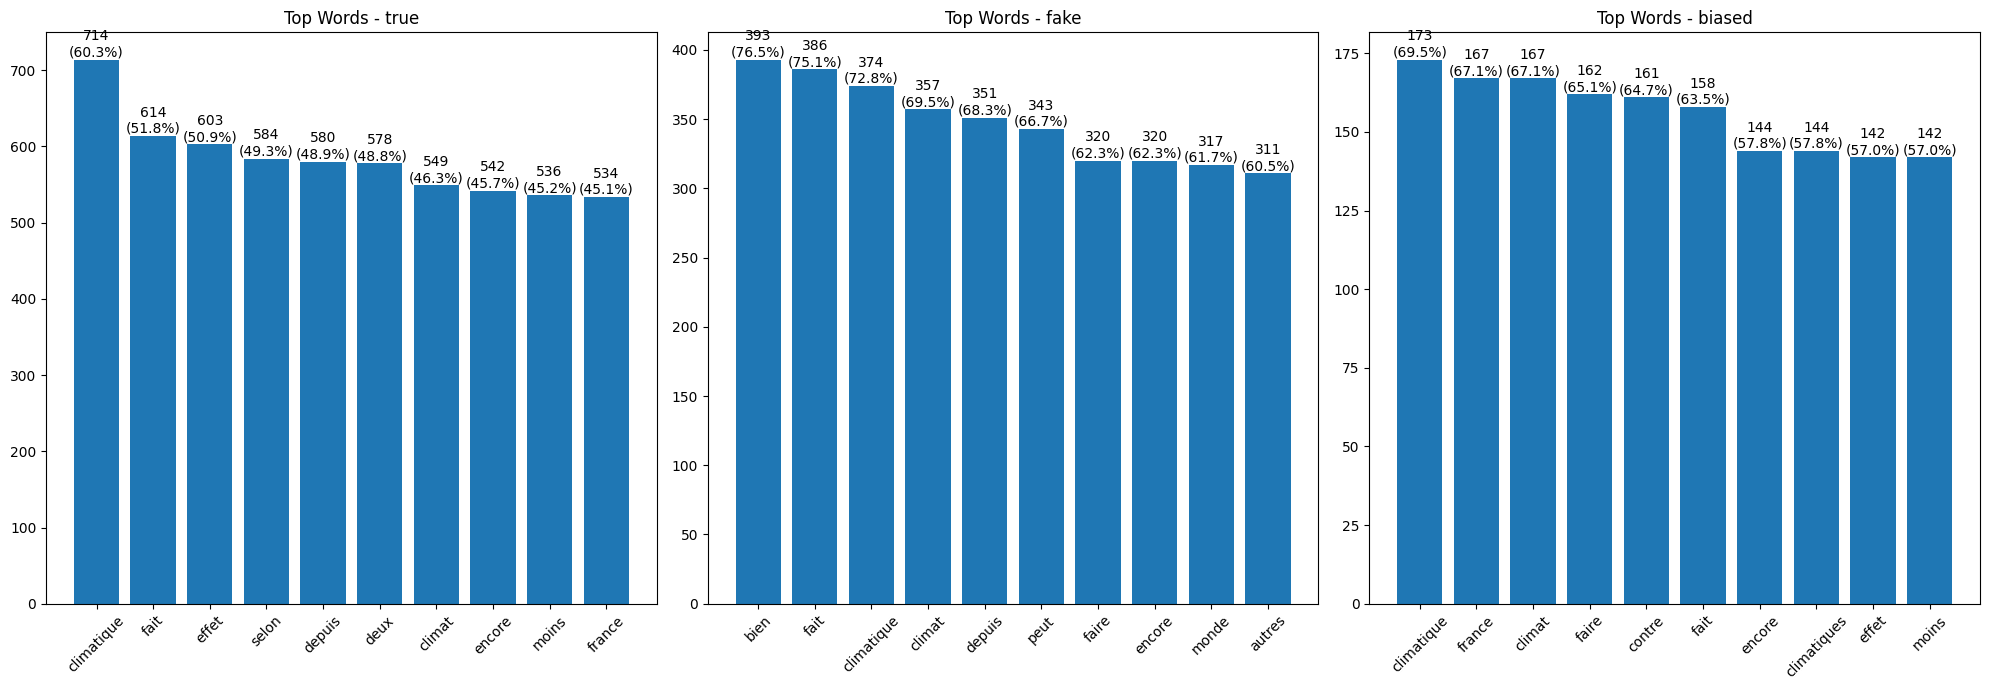

In [4]:
def get_word_frequencies_by_label(df):
    from collections import Counter
    import re
    
    french_stop_words = set(['le', 'la', 'les', 'de', 'des', 'du', 'et', 'en', 'un', 'une',
                            'pour', 'par', 'sur', 'dans', 'avec', 'est', 'sont', 'qui', 'que',
                            'aux', 'ce', 'ces', 'dans', 'mais', 'ou', 'où', 'donc',
                            'l', 'à', 'd', 'a', 'il', 'plus', 'pas', 'au', 'ne', 'n',
                            'nous', 'je', 'tu', 'ils', 'elle', 'elles', 'nous', 'vous',
                            'leur', 'leurs', 'alors', 'si', 'cette', 'ces', 'se', 'entre',
                            'aussi', 'tout', 'tous', 'très', 'sans', 'sous', 'sur', 'c', 's', 'qu', 'ont', 'comme', 'être', 'même'])
    
    fig, axes = plt.subplots(1, len(df['Label'].unique()), figsize=(20, 7))
    
    for idx, label in enumerate(df['Label'].unique()):
        label_texts = df[df['Label'] == label]['Text']
        total_docs = len(label_texts)
        
        word_doc_count = Counter()
        
        for text in label_texts:
            words = set(re.findall(r'\b\w+\b', text.lower()))
            valid_words = {word for word in words if word not in french_stop_words and len(word) > 3}
            word_doc_count.update(valid_words)
        
        top_10 = word_doc_count.most_common(10)
        words, doc_counts = zip(*top_10)
        
        percentages = [count/total_docs * 100 for count in doc_counts]
        
        ax = axes[idx]
        bars = ax.bar(words, doc_counts)
        ax.set_title(f'Top Words - {label}')
        ax.tick_params(axis='x', rotation=45)
        
        for bar, count, pct in zip(bars, doc_counts, percentages):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{count}\n({pct:.1f}%)',
                   ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

get_word_frequencies_by_label(train_df)

CameBERT

In [6]:
from sklearn.model_selection import train_test_split
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

X = train_df['Text']
y = train_df['Label']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Dataset sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")

print("\nClass distributions:")
print("\nTraining set:")
print(y_train.value_counts(normalize=True).round(3) * 100)
print("\nValidation set:")
print(y_val.value_counts(normalize=True).round(3) * 100)

tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

def tokenize_function(examples):
    return tokenizer(
        examples['text'], 
        padding='max_length', 
        truncation=True, 
        max_length=512
    )

label_dict = {'true': 0, 'fake': 1, 'biased': 2}
y_train = y_train.map(label_dict)
y_val = y_val.map(label_dict)

train_dataset = Dataset.from_dict({
    'text': X_train.tolist(),
    'label': y_train.tolist()
})

val_dataset = Dataset.from_dict({
    'text': X_val.tolist(),
    'label': y_val.tolist()
})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

model = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    num_labels=3,
    problem_type="single_label_classification"
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    
    report = classification_report(
        labels, 
        predictions, 
        target_names=['true', 'fake', 'biased'],
        output_dict=True
    )
    
    metrics = {
        'accuracy': accuracy,
    }
    
    for cls in ['true', 'fake', 'biased']:
        metrics[f'{cls}_precision'] = report[cls]['precision']
        metrics[f'{cls}_recall'] = report[cls]['recall']
        metrics[f'{cls}_f1'] = report[cls]['f1-score']
    
    return metrics

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
    report_to="none",
    no_cuda=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("Starting training...")
trainer.train()

print("\nEvaluating on validation set...")
val_results = trainer.evaluate()
print("\nValidation set results:")
print(val_results)

model_save_path = './final_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"\nModel saved to {model_save_path}")

Dataset sizes:
Training set: 1558 samples
Validation set: 390 samples

Class distributions:

Training set:
Label
true      60.8
fake      26.4
biased    12.8
Name: proportion, dtype: float64

Validation set:
Label
true      60.8
fake      26.4
biased    12.8
Name: proportion, dtype: float64


Map:   0%|          | 0/1558 [00:00<?, ? examples/s]

Map:   0%|          | 0/390 [00:00<?, ? examples/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\projects\SII\prediction_competition\venv\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


  0%|          | 0/490 [00:00<?, ?it/s]

{'loss': 1.1007, 'grad_norm': 1.8435953855514526, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.1}
{'loss': 1.09, 'grad_norm': 1.8364834785461426, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.2}
{'loss': 1.0674, 'grad_norm': 1.8840504884719849, 'learning_rate': 3e-06, 'epoch': 0.31}
{'loss': 1.0359, 'grad_norm': 1.6889255046844482, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.41}
{'loss': 1.0196, 'grad_norm': 1.9775112867355347, 'learning_rate': 5e-06, 'epoch': 0.51}
{'loss': 0.9755, 'grad_norm': 1.8884270191192627, 'learning_rate': 6e-06, 'epoch': 0.61}
{'loss': 0.9639, 'grad_norm': 1.0684505701065063, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.71}
{'loss': 0.9622, 'grad_norm': 1.1277413368225098, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.82}
{'loss': 0.9026, 'grad_norm': 2.0331246852874756, 'learning_rate': 9e-06, 'epoch': 0.92}


  0%|          | 0/25 [00:00<?, ?it/s]

c:\projects\SII\prediction_competition\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\projects\SII\prediction_competition\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\projects\SII\prediction_competition\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

{'eval_loss': 0.8775257468223572, 'eval_accuracy': 0.6076923076923076, 'eval_true_precision': 0.6076923076923076, 'eval_true_recall': 1.0, 'eval_true_f1': 0.7559808612440191, 'eval_fake_precision': 0.0, 'eval_fake_recall': 0.0, 'eval_fake_f1': 0.0, 'eval_biased_precision': 0.0, 'eval_biased_recall': 0.0, 'eval_biased_f1': 0.0, 'eval_runtime': 4.9605, 'eval_samples_per_second': 78.621, 'eval_steps_per_second': 5.04, 'epoch': 1.0}
{'loss': 0.96, 'grad_norm': 1.5210883617401123, 'learning_rate': 1e-05, 'epoch': 1.02}
{'loss': 0.8329, 'grad_norm': 1.2310326099395752, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.12}
{'loss': 0.8367, 'grad_norm': 1.1268155574798584, 'learning_rate': 1.2e-05, 'epoch': 1.22}
{'loss': 0.8096, 'grad_norm': 3.8970699310302734, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.33}
{'loss': 0.7308, 'grad_norm': 2.9098703861236572, 'learning_rate': 1.4000000000000001e-05, 'epoch': 1.43}
{'loss': 0.7008, 'grad_norm': 7.974732398986816, 'learning_rate': 1.5e-

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.5942352414131165, 'eval_accuracy': 0.7974358974358975, 'eval_true_precision': 0.8421052631578947, 'eval_true_recall': 0.9451476793248945, 'eval_true_f1': 0.8906560636182903, 'eval_fake_precision': 0.6929824561403509, 'eval_fake_recall': 0.7669902912621359, 'eval_fake_f1': 0.728110599078341, 'eval_biased_precision': 0.8, 'eval_biased_recall': 0.16, 'eval_biased_f1': 0.26666666666666666, 'eval_runtime': 4.7036, 'eval_samples_per_second': 82.915, 'eval_steps_per_second': 5.315, 'epoch': 2.0}
{'loss': 0.6146, 'grad_norm': 2.549483299255371, 'learning_rate': 2e-05, 'epoch': 2.04}
{'loss': 0.507, 'grad_norm': 5.717850208282471, 'learning_rate': 2.1e-05, 'epoch': 2.14}
{'loss': 0.5709, 'grad_norm': 17.464988708496094, 'learning_rate': 2.2000000000000003e-05, 'epoch': 2.24}
{'loss': 0.7097, 'grad_norm': 3.0137178897857666, 'learning_rate': 2.3000000000000003e-05, 'epoch': 2.35}
{'loss': 0.6676, 'grad_norm': 4.1932477951049805, 'learning_rate': 2.4e-05, 'epoch': 2.45}
{'loss': 0

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.6144647598266602, 'eval_accuracy': 0.7871794871794872, 'eval_true_precision': 0.828996282527881, 'eval_true_recall': 0.9409282700421941, 'eval_true_f1': 0.8814229249011858, 'eval_fake_precision': 0.8133333333333334, 'eval_fake_recall': 0.5922330097087378, 'eval_fake_f1': 0.6853932584269663, 'eval_biased_precision': 0.5, 'eval_biased_recall': 0.46, 'eval_biased_f1': 0.4791666666666667, 'eval_runtime': 4.7304, 'eval_samples_per_second': 82.445, 'eval_steps_per_second': 5.285, 'epoch': 3.0}
{'loss': 0.5361, 'grad_norm': 15.835960388183594, 'learning_rate': 3e-05, 'epoch': 3.06}
{'loss': 0.4315, 'grad_norm': 7.087944507598877, 'learning_rate': 3.1e-05, 'epoch': 3.16}
{'loss': 0.4085, 'grad_norm': 6.438492298126221, 'learning_rate': 3.2000000000000005e-05, 'epoch': 3.27}
{'loss': 0.4406, 'grad_norm': 6.432519435882568, 'learning_rate': 3.3e-05, 'epoch': 3.37}
{'loss': 0.3904, 'grad_norm': 8.108928680419922, 'learning_rate': 3.4000000000000007e-05, 'epoch': 3.47}
{'loss': 0.4

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.5756856203079224, 'eval_accuracy': 0.7846153846153846, 'eval_true_precision': 0.85, 'eval_true_recall': 0.9324894514767933, 'eval_true_f1': 0.8893360160965795, 'eval_fake_precision': 0.8405797101449275, 'eval_fake_recall': 0.5631067961165048, 'eval_fake_f1': 0.6744186046511628, 'eval_biased_precision': 0.4426229508196721, 'eval_biased_recall': 0.54, 'eval_biased_f1': 0.4864864864864865, 'eval_runtime': 4.7809, 'eval_samples_per_second': 81.575, 'eval_steps_per_second': 5.229, 'epoch': 4.0}
{'loss': 0.3741, 'grad_norm': 3.2587528228759766, 'learning_rate': 4e-05, 'epoch': 4.08}
{'loss': 0.3076, 'grad_norm': 2.971088409423828, 'learning_rate': 4.1e-05, 'epoch': 4.18}
{'loss': 0.3422, 'grad_norm': 4.136599540710449, 'learning_rate': 4.2e-05, 'epoch': 4.29}
{'loss': 0.3482, 'grad_norm': 18.74818992614746, 'learning_rate': 4.3e-05, 'epoch': 4.39}
{'loss': 0.3594, 'grad_norm': 16.509302139282227, 'learning_rate': 4.4000000000000006e-05, 'epoch': 4.49}
{'loss': 0.3259, 'grad_n

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.6063242554664612, 'eval_accuracy': 0.8179487179487179, 'eval_true_precision': 0.8804780876494024, 'eval_true_recall': 0.9324894514767933, 'eval_true_f1': 0.9057377049180327, 'eval_fake_precision': 0.7835051546391752, 'eval_fake_recall': 0.7378640776699029, 'eval_fake_f1': 0.76, 'eval_biased_precision': 0.5238095238095238, 'eval_biased_recall': 0.44, 'eval_biased_f1': 0.4782608695652174, 'eval_runtime': 4.7401, 'eval_samples_per_second': 82.277, 'eval_steps_per_second': 5.274, 'epoch': 5.0}
{'train_runtime': 342.6343, 'train_samples_per_second': 22.736, 'train_steps_per_second': 1.43, 'train_loss': 0.6084241064227357, 'epoch': 5.0}

Evaluating on validation set...


  0%|          | 0/25 [00:00<?, ?it/s]


Validation set results:
{'eval_loss': 0.6063242554664612, 'eval_accuracy': 0.8179487179487179, 'eval_true_precision': 0.8804780876494024, 'eval_true_recall': 0.9324894514767933, 'eval_true_f1': 0.9057377049180327, 'eval_fake_precision': 0.7835051546391752, 'eval_fake_recall': 0.7378640776699029, 'eval_fake_f1': 0.76, 'eval_biased_precision': 0.5238095238095238, 'eval_biased_recall': 0.44, 'eval_biased_f1': 0.4782608695652174, 'eval_runtime': 4.7243, 'eval_samples_per_second': 82.553, 'eval_steps_per_second': 5.292, 'epoch': 5.0}

Model saved to ./final_model


BERT

In [7]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

X = train_df['Text']
y = train_df['Label']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Dataset sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")

print("\nClass distributions:")
print("\nTraining set:")
print(y_train.value_counts(normalize=True).round(3) * 100)
print("\nValidation set:")
print(y_val.value_counts(normalize=True).round(3) * 100)

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_function(examples):
    return tokenizer(
        examples['text'], 
        padding='max_length', 
        truncation=True, 
        max_length=512
    )

label_dict = {'true': 0, 'fake': 1, 'biased': 2}
y_train = y_train.map(label_dict)
y_val = y_val.map(label_dict)

train_dataset = Dataset.from_dict({
    'text': X_train.tolist(),
    'label': y_train.tolist()
})

val_dataset = Dataset.from_dict({
    'text': X_val.tolist(),
    'label': y_val.tolist()
})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=3,
    problem_type="single_label_classification"
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    
    report = classification_report(
        labels, 
        predictions, 
        target_names=['true', 'fake', 'biased'],
        output_dict=True
    )
    
    metrics = {
        'accuracy': accuracy,
    }
    
    for cls in ['true', 'fake', 'biased']:
        metrics[f'{cls}_precision'] = report[cls]['precision']
        metrics[f'{cls}_recall'] = report[cls]['recall']
        metrics[f'{cls}_f1'] = report[cls]['f1-score']
    
    return metrics

training_args = TrainingArguments(
    output_dir='./results_bert',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_bert',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
    report_to="none",
    no_cuda=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("Starting training...")
trainer.train()

print("\nEvaluating on validation set...")
val_results = trainer.evaluate()
print("\nValidation set results:")
print(val_results)

model_save_path = './final_model_bert'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"\nModel saved to {model_save_path}")

Dataset sizes:
Training set: 1558 samples
Validation set: 390 samples

Class distributions:

Training set:
Label
true      60.8
fake      26.4
biased    12.8
Name: proportion, dtype: float64

Validation set:
Label
true      60.8
fake      26.4
biased    12.8
Name: proportion, dtype: float64


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

c:\projects\SII\prediction_competition\venv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Paul\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Map:   0%|          | 0/1558 [00:00<?, ? examples/s]

Map:   0%|          | 0/390 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\projects\SII\prediction_competition\venv\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


  0%|          | 0/490 [00:00<?, ?it/s]

{'loss': 1.1154, 'grad_norm': 3.7609503269195557, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.1}
{'loss': 1.0913, 'grad_norm': 4.361810684204102, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.2}
{'loss': 1.0355, 'grad_norm': 3.531801462173462, 'learning_rate': 3e-06, 'epoch': 0.31}
{'loss': 0.9937, 'grad_norm': 3.438694953918457, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.41}
{'loss': 0.9407, 'grad_norm': 13.045997619628906, 'learning_rate': 5e-06, 'epoch': 0.51}
{'loss': 0.914, 'grad_norm': 29.98123550415039, 'learning_rate': 6e-06, 'epoch': 0.61}
{'loss': 0.9123, 'grad_norm': 5.478649139404297, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.71}
{'loss': 0.9229, 'grad_norm': 5.200941562652588, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.82}
{'loss': 0.7937, 'grad_norm': 7.173644065856934, 'learning_rate': 9e-06, 'epoch': 0.92}


  0%|          | 0/25 [00:00<?, ?it/s]

c:\projects\SII\prediction_competition\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\projects\SII\prediction_competition\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\projects\SII\prediction_competition\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

{'eval_loss': 0.7403398752212524, 'eval_accuracy': 0.6974358974358974, 'eval_true_precision': 0.7003058103975535, 'eval_true_recall': 0.9662447257383966, 'eval_true_f1': 0.8120567375886525, 'eval_fake_precision': 0.6825396825396826, 'eval_fake_recall': 0.4174757281553398, 'eval_fake_f1': 0.5180722891566265, 'eval_biased_precision': 0.0, 'eval_biased_recall': 0.0, 'eval_biased_f1': 0.0, 'eval_runtime': 97.225, 'eval_samples_per_second': 4.011, 'eval_steps_per_second': 0.257, 'epoch': 1.0}
{'loss': 0.8639, 'grad_norm': 12.487739562988281, 'learning_rate': 1e-05, 'epoch': 1.02}
{'loss': 0.73, 'grad_norm': 11.36532974243164, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.12}
{'loss': 0.7307, 'grad_norm': 5.991157054901123, 'learning_rate': 1.2e-05, 'epoch': 1.22}
{'loss': 0.6559, 'grad_norm': 13.502420425415039, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.33}
{'loss': 0.6804, 'grad_norm': 19.20508575439453, 'learning_rate': 1.4000000000000001e-05, 'epoch': 1.43}
{'loss': 0.682

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.6092954277992249, 'eval_accuracy': 0.7384615384615385, 'eval_true_precision': 0.8207171314741036, 'eval_true_recall': 0.869198312236287, 'eval_true_f1': 0.8442622950819673, 'eval_fake_precision': 0.693069306930693, 'eval_fake_recall': 0.6796116504854369, 'eval_fake_f1': 0.6862745098039216, 'eval_biased_precision': 0.3157894736842105, 'eval_biased_recall': 0.24, 'eval_biased_f1': 0.2727272727272727, 'eval_runtime': 94.1121, 'eval_samples_per_second': 4.144, 'eval_steps_per_second': 0.266, 'epoch': 2.0}
{'loss': 0.6039, 'grad_norm': 8.653965950012207, 'learning_rate': 2e-05, 'epoch': 2.04}
{'loss': 0.5497, 'grad_norm': 5.5573344230651855, 'learning_rate': 2.1e-05, 'epoch': 2.14}
{'loss': 0.589, 'grad_norm': 21.201740264892578, 'learning_rate': 2.2000000000000003e-05, 'epoch': 2.24}
{'loss': 0.608, 'grad_norm': 11.505034446716309, 'learning_rate': 2.3000000000000003e-05, 'epoch': 2.35}
{'loss': 0.5311, 'grad_norm': 15.8158540725708, 'learning_rate': 2.4e-05, 'epoch': 2.45}

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.646979570388794, 'eval_accuracy': 0.7538461538461538, 'eval_true_precision': 0.8701298701298701, 'eval_true_recall': 0.8481012658227848, 'eval_true_f1': 0.8589743589743589, 'eval_fake_precision': 0.6752136752136753, 'eval_fake_recall': 0.7669902912621359, 'eval_fake_f1': 0.7181818181818181, 'eval_biased_precision': 0.3333333333333333, 'eval_biased_recall': 0.28, 'eval_biased_f1': 0.30434782608695654, 'eval_runtime': 94.7952, 'eval_samples_per_second': 4.114, 'eval_steps_per_second': 0.264, 'epoch': 3.0}
{'loss': 0.5671, 'grad_norm': 23.684246063232422, 'learning_rate': 3e-05, 'epoch': 3.06}
{'loss': 0.4904, 'grad_norm': 6.065150260925293, 'learning_rate': 3.1e-05, 'epoch': 3.16}
{'loss': 0.3967, 'grad_norm': 11.546878814697266, 'learning_rate': 3.2000000000000005e-05, 'epoch': 3.27}
{'loss': 0.7471, 'grad_norm': 13.565553665161133, 'learning_rate': 3.3e-05, 'epoch': 3.37}
{'loss': 0.4349, 'grad_norm': 9.204864501953125, 'learning_rate': 3.4000000000000007e-05, 'epoch': 

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.6597886085510254, 'eval_accuracy': 0.7025641025641025, 'eval_true_precision': 0.8062015503875969, 'eval_true_recall': 0.8776371308016878, 'eval_true_f1': 0.8404040404040404, 'eval_fake_precision': 0.8431372549019608, 'eval_fake_recall': 0.4174757281553398, 'eval_fake_f1': 0.5584415584415584, 'eval_biased_precision': 0.2839506172839506, 'eval_biased_recall': 0.46, 'eval_biased_f1': 0.3511450381679389, 'eval_runtime': 94.8254, 'eval_samples_per_second': 4.113, 'eval_steps_per_second': 0.264, 'epoch': 4.0}
{'loss': 0.3624, 'grad_norm': 13.873054504394531, 'learning_rate': 4e-05, 'epoch': 4.08}
{'loss': 0.6606, 'grad_norm': 13.228715896606445, 'learning_rate': 4.1e-05, 'epoch': 4.18}
{'loss': 0.4095, 'grad_norm': 8.138769149780273, 'learning_rate': 4.2e-05, 'epoch': 4.29}
{'loss': 0.513, 'grad_norm': 12.611298561096191, 'learning_rate': 4.3e-05, 'epoch': 4.39}
{'loss': 0.4195, 'grad_norm': 14.502313613891602, 'learning_rate': 4.4000000000000006e-05, 'epoch': 4.49}
{'loss': 

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.7178787589073181, 'eval_accuracy': 0.7615384615384615, 'eval_true_precision': 0.8253968253968254, 'eval_true_recall': 0.8776371308016878, 'eval_true_f1': 0.8507157464212679, 'eval_fake_precision': 0.7043478260869566, 'eval_fake_recall': 0.7864077669902912, 'eval_fake_f1': 0.7431192660550459, 'eval_biased_precision': 0.34782608695652173, 'eval_biased_recall': 0.16, 'eval_biased_f1': 0.2191780821917808, 'eval_runtime': 220.2571, 'eval_samples_per_second': 1.771, 'eval_steps_per_second': 0.114, 'epoch': 5.0}
{'train_runtime': 3320.9957, 'train_samples_per_second': 2.346, 'train_steps_per_second': 0.148, 'train_loss': 0.635024296994112, 'epoch': 5.0}

Evaluating on validation set...


  0%|          | 0/25 [00:00<?, ?it/s]


Validation set results:
{'eval_loss': 0.7178787589073181, 'eval_accuracy': 0.7615384615384615, 'eval_true_precision': 0.8253968253968254, 'eval_true_recall': 0.8776371308016878, 'eval_true_f1': 0.8507157464212679, 'eval_fake_precision': 0.7043478260869566, 'eval_fake_recall': 0.7864077669902912, 'eval_fake_f1': 0.7431192660550459, 'eval_biased_precision': 0.34782608695652173, 'eval_biased_recall': 0.16, 'eval_biased_f1': 0.2191780821917808, 'eval_runtime': 164.8533, 'eval_samples_per_second': 2.366, 'eval_steps_per_second': 0.152, 'epoch': 5.0}

Model saved to ./final_model_bert


Map:   0%|          | 0/486 [00:00<?, ? examples/s]

C:\Users\Paul\AppData\Local\Temp\ipykernel_10332\824610127.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/61 [00:00<?, ?it/s]

=== Test Dataset Analysis ===

=== Text Statistics ===
Mean text length: 5372.96
Median text length: 3721.00
Min text length: 1057.00
Max text length: 42164.00
Mean word count: 852.15
Median word count: 599.50

=== Label Distribution ===
true: 320 (65.84%)
fake: 132 (27.16%)
biased: 34 (7.0%)


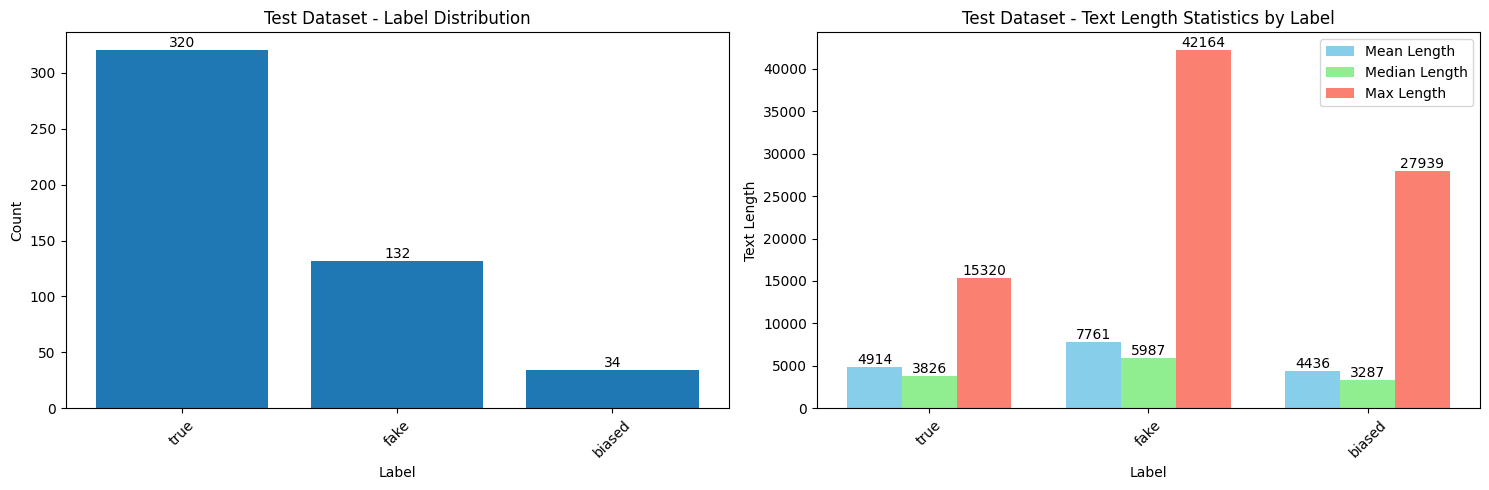

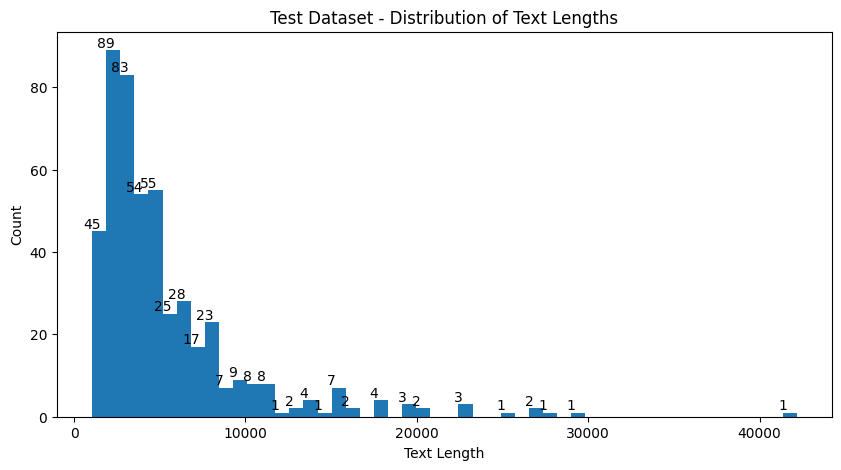

In [13]:
from transformers import CamembertTokenizer, CamembertForSequenceClassification, Trainer
from datasets import Dataset
import numpy as np

tokenizer = CamembertTokenizer.from_pretrained('./final_model')

def tokenize_function(examples):
    return tokenizer(
        examples['text'], 
        padding='max_length', 
        truncation=True, 
        max_length=512
    )

model = CamembertForSequenceClassification.from_pretrained('./final_model')

test_dataset = Dataset.from_dict({
    'text': test_df['Text'].tolist(),
})
test_dataset = test_dataset.map(tokenize_function, batched=True)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
)

predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

label_dict_reverse = {0: 'true', 1: 'fake', 2: 'biased'}
test_df['Label'] = [label_dict_reverse[pred] for pred in predicted_labels]

final_predictions = test_df[['Text', 'Label']].copy()
final_predictions.to_csv('predictions.csv', index=False)

test_stats = inspect_dataset(final_predictions, "Test Dataset")